Some of the imports are not useful yet

In [131]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
import tensorflow as tf
from yaafelib import *

Download GTZAN dataset once

In [3]:
def downloadGTZAN():
    filename = 'genres.tar.gz'
    if not os.path.exists(filename):
        filename, _ = urlretrieve('http://opihi.cs.uvic.ca/sound/genres.tar.gz', filename)
    else:
        print('File ' + filename + ' exists')
    
    return filename
filename = downloadGTZAN()

Extract files from .tar.gz

In [4]:
num_classes = 10

def extract(filename):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root):
        print('File %s already extracted' % (root))
    else:
        print('Extracting %s ' % filename)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))
                    if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders not found.' % (num_classes))
    print(data_folders)
    return data_folders

folders = extract(filename)

Extracting genres.tar.gz 
['genres/blues', 'genres/classical', 'genres/country', 'genres/disco', 'genres/hiphop', 'genres/jazz', 'genres/metal', 'genres/pop', 'genres/reggae', 'genres/rock']


In [31]:
def get_features(audio_file):
    if os.path.exists(audio_file):
        print('Getting features from ' + audio_file)
    else:
        raise Exception('File ' + audio_file + ' not found')
    fp = FeaturePlan(sample_rate=22050, normalize=1)
    # Features that seems to be most often used, so they are good to start with.
    fp.addFeature('mfcc: MFCC')
    fp.addFeature('zcr: ZCR')
    fp.addFeature('spectral_shape: SpectralShapeStatistics')
    fp.addFeature('magnitude_spectrum: MagnitudeSpectrum')
    df = fp.getDataFlow()
    engine = Engine()
    engine.load(df)
    afp = AudioFileProcessor()
    afp.setOutputFormat('csv', 'features', {'Precision': '8', 'Metadata': 'False'})
    afp.processFile(engine, audio_file)
    engine.flush()
    feats = engine.readAllOutputs()
    return feats

def load_genre(folder):
    print('Loading genre from folder ' + folder)
    samples = os.listdir(folder)
    dataset =[]
    for sample in os.listdir(folder):
        sample_file = os.path.join(folder, sample)
        if sample.endswith('.au'):
            features = get_features(sample_file)
            dataset.append(features)
    return dataset

def pickle(data_folders):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename):
            print('%s already pickled' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_genre(folder)
            with open(set_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    return dataset_names

pickled_datasets = pickle(folders)

Pickling genres/blues.pickle.
Loading genre from folder genres/blues
Getting features from genres/blues/blues.00004.au
Getting features from genres/blues/blues.00086.au
Getting features from genres/blues/blues.00009.au
Getting features from genres/blues/blues.00022.au
Getting features from genres/blues/blues.00078.au
Getting features from genres/blues/blues.00066.au
Getting features from genres/blues/blues.00005.au
Getting features from genres/blues/blues.00057.au
Getting features from genres/blues/blues.00056.au
Getting features from genres/blues/blues.00019.au
Getting features from genres/blues/blues.00071.au
Getting features from genres/blues/blues.00097.au
Getting features from genres/blues/blues.00014.au
Getting features from genres/blues/blues.00099.au
Getting features from genres/blues/blues.00080.au
Getting features from genres/blues/blues.00094.au
Getting features from genres/blues/blues.00093.au
Getting features from genres/blues/blues.00065.au
Getting features from genres/bl

['genres/blues.pickle',
 'genres/classical.pickle',
 'genres/country.pickle',
 'genres/disco.pickle',
 'genres/hiphop.pickle',
 'genres/jazz.pickle',
 'genres/metal.pickle',
 'genres/pop.pickle',
 'genres/reggae.pickle',
 'genres/rock.pickle']

Now the data is pickled, thus the feature extraction doesn't have to be repeated. 

Let's vizualize something

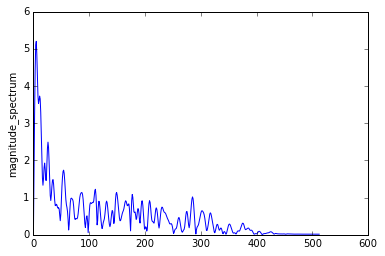

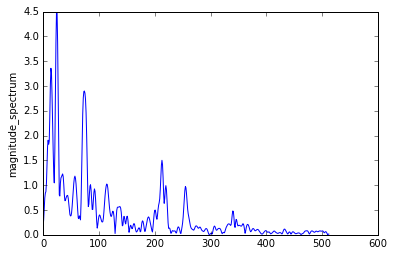

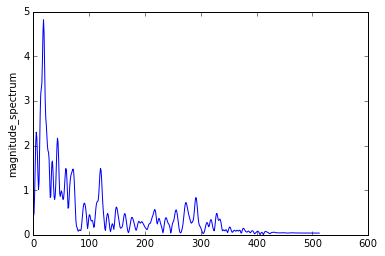

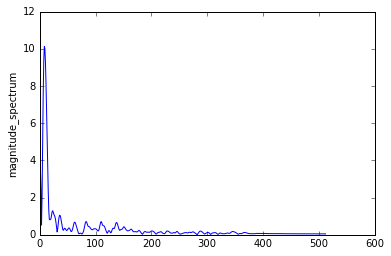

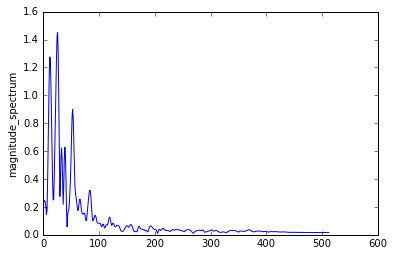

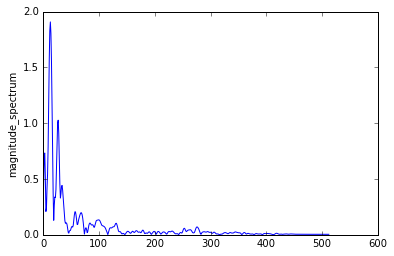

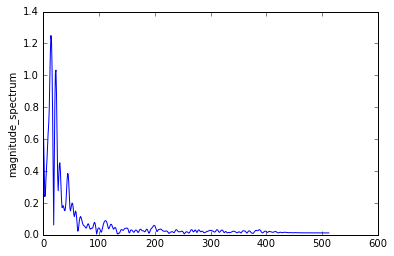

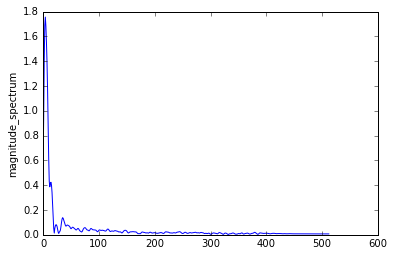

In [43]:
%matplotlib inline  

def visualize(filename, sample, feature):
    with open(filename, 'r') as f:
        unpickled = pickle.load(f)
        f = unpickled[sample][feature]
        plt.plot(f[0])
        plt.ylabel(feature)
        plt.show()

visualize('genres/rock.pickle', 0, 'magnitude_spectrum')
visualize('genres/rock.pickle', 1, 'magnitude_spectrum')
visualize('genres/rock.pickle', 2, 'magnitude_spectrum')
visualize('genres/rock.pickle', 3, 'magnitude_spectrum')
visualize('genres/blues.pickle', 0, 'magnitude_spectrum')
visualize('genres/blues.pickle', 1, 'magnitude_spectrum')
visualize('genres/blues.pickle', 2, 'magnitude_spectrum')
visualize('genres/blues.pickle', 3, 'magnitude_spectrum')

Training set and test set are needed. In addition, they have to be shuffeled/randomized somehow.

In [130]:
pickled_datasets = ['blues.pickle','classical.pickle','country.pickle','disco.pickle','hiphop.pickle','jazz.pickle',
                    'metal.pickle','pop.pickle','reggae.pickle','rock.pickle']

def unpickle(filename):
    with open('genres/' + filename, 'r') as f:
        return pickle.load(f)
    
def evens(dataset):
    return dataset[::2]
def odds(dataset):
    return dataset[1::2]

def dataset_with_labels(filename):
    dataset = unpickle(filename)
    return dataset, [os.path.splitext(filename)[0] for count in xrange(len(dataset))]

datasets = map(dataset_with_labels, pickled_datasets)
features = [features for genre in datasets for features in genre[0]]
labels = [label for genre in datasets for label in genre[1]]

train_features = odds(features)
train_labels = odds(labels)
test_features = evens(features)
test_labels = evens(labels)

def randomize(dataset, labels):
    permutation = np.random.permutation(len(labels))
    shuffled_dataset = np.asarray(dataset)[permutation]
    shuffled_labels = np.asarray(labels)[permutation]
    return shuffled_dataset, shuffled_labels

train_features, train_labels = randomize(train_features, train_labels)
test_features, test_labels = randomize(test_features, test_labels)

try:
    f = open('train_and_test_data.pickle', 'wb')
    save = {
        'train_features': train_features,
        'train_labels': train_labels,
        'test_features': test_features,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Now, we can go to TensorFlow

In [ ]:
with open('train_and_test_data.pickle', 'rb') as f:
    save = pickle.load(f)
    train_features = save['train_features']
    train_labels = save['train_labels']
    test_features = save['test_features']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory


